<a href="https://colab.research.google.com/github/Shubham-Gandhi-018/CS_715-Final-Project/blob/main/mGRN_HAR_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SECTION 1 — Install & Import Libraries**

In [ ]:
# Install required libs (Colab only)
!pip install seaborn

# Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -q "UCI HAR Dataset.zip"

--2025-12-03 16:57:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [                 <=>]  58.17M  17.1MB/s    in 4.2s    

2025-12-03 16:57:49 (13.9 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]



# **SECTION 2 — Load the HAR Dataset (9 sensor channels)**

In [ ]:
# Load a single HAR subset (train/test)
def load_inertial_signals(subset_name, num_samples):
    signals = []
    signal_types = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x", "body_gyro_y", "body_gyro_z",
        "total_acc_x", "total_acc_y", "total_acc_z"
    ]
    base_path = f"UCI HAR Dataset/{subset_name}/Inertial Signals"

    for sig in signal_types:
        path = f"{base_path}/{sig}_{subset_name}.txt"
        data = np.loadtxt(path).reshape(num_samples, 128)
        signals.append(data)

    return np.stack(signals, axis=2)   # (samples, 128, 9)

# Load labels
y_train = np.loadtxt("UCI HAR Dataset/train/y_train.txt").astype(int)
y_test  = np.loadtxt("UCI HAR Dataset/test/y_test.txt").astype(int)

# Load data
X_train = load_inertial_signals("train", len(y_train))
X_test  = load_inertial_signals("test",  len(y_test))

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42
)


📌 Explanation for the above code:

  - HAR contains time-series sensor data from smartphone accelerometers & gyroscopes.

  - Each sample is a window of 128 time steps × 9 features.

  - We load all inertial signal files and stack them into a single tensor.

# **SECTION 3 — Dataset Class & DataLoaders**

In [ ]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y - 1, dtype=torch.long)  # convert to 0–5

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(HARDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(HARDataset(X_val,   y_val),   batch_size=64, shuffle=False)
test_loader  = DataLoader(HARDataset(X_test,  y_test),  batch_size=64, shuffle=False)


📌 Explanation for the above code:

  - Converts NumPy arrays → PyTorch tensors

  - Labels are converted to 0–5

  - DataLoaders handle batching & shuffling

# **SECTION 4 — Define the Models**

Implemented:

1. mGRN (our proposed model)

2. GRU baseline

3. LSTM baseline

**4A — MarginalGRU (sub-module for mGRN)**

In [ ]:
class MarginalGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W_r = nn.Linear(input_dim, hidden_dim)
        self.U_r = nn.Linear(hidden_dim, hidden_dim)

        self.W_z = nn.Linear(input_dim, hidden_dim)
        self.U_z = nn.Linear(hidden_dim, hidden_dim)

        self.W_h = nn.Linear(input_dim, hidden_dim)
        self.U_h = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x_t, h_prev):
        r = torch.sigmoid(self.W_r(x_t) + self.U_r(h_prev))
        z = torch.sigmoid(self.W_z(x_t) + self.U_z(h_prev))
        h_tilde = torch.tanh(self.W_h(x_t) + r * self.U_h(h_prev))
        h = (1 - z) * h_prev + z * h_tilde
        return h, h_tilde


**4B — mGRN Full Model**

Grouped HAR features:

  - Group 1 (0–6) → accelerometer + body gyroscope

  - Group 2 (6–9) → total acceleration

In [ ]:
class mGRN(nn.Module):
    def __init__(self, input_dim, groups, m_hidden=32, j_hidden=64, num_classes=6):
        super().__init__()
        self.groups = groups
        self.num_groups = len(groups)

        # One marginal GRU per group
        self.marginals = nn.ModuleList([
            MarginalGRU(e - s, m_hidden)
            for (s, e) in groups
        ])

        # Joint update gate
        self.W_z = nn.Linear(input_dim, j_hidden)
        self.U_z = nn.Linear(j_hidden, j_hidden)

        # Combine marginal candidates
        self.U_c = nn.ModuleList([
            nn.Linear(m_hidden, j_hidden, bias=False)
            for _ in range(self.num_groups)
        ])
        self.b_c = nn.Parameter(torch.zeros(j_hidden))

        # Classification layer
        self.fc = nn.Linear(j_hidden, num_classes)

    def forward(self, x):
        B, T, D = x.shape
        h_m = [x.new_zeros((B, 32)) for _ in self.groups]
        h_joint = x.new_zeros((B, 64))

        for t in range(T):
            x_t = x[:, t, :]
            cand = []

            for gi, (s, e) in enumerate(self.groups):
                x_g = x_t[:, s:e]
                h_m[gi], h_tilde = self.marginals[gi](x_g, h_m[gi])
                cand.append(h_tilde)

            joint_in = sum(self.U_c[i](cand[i]) for i in range(self.num_groups))
            h_tilde_joint = torch.tanh(joint_in + self.b_c)

            z = torch.sigmoid(self.W_z(x_t) + self.U_z(h_joint))
            h_joint = (1 - z) * h_joint + z * h_tilde_joint

        return self.fc(h_joint)


**4C — GRU Baseline**

In [ ]:
class GRUBaseline(nn.Module):
    def __init__(self, input_dim=9, hidden=64, num_classes=6):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)   # (B,T,H)
        return self.fc(out[:, -1, :])


**4D — LSTM Baseline**

In [ ]:
class LSTMBaseline(nn.Module):
    def __init__(self, input_dim=9, hidden=64, num_classes=6):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


# **SECTION 5 — Unified Hyperparameters**

In [ ]:
LR = 1e-3
EPOCHS = 20

criterion = nn.CrossEntropyLoss()


# **SECTION 6 — Training & Evaluation Loops**

In [ ]:
def train_epoch(model, loader, optim):
    model.train()
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = criterion(pred, yb)

        optim.zero_grad()
        loss.backward()
        optim.step()

        correct += (pred.argmax(1) == yb).sum().item()
        total += len(yb)

    return correct / total

def eval_epoch(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            correct += (pred.argmax(1) == yb).sum().item()
            total += len(yb)
    return correct / total


# **SECTION 7 — Train All Models**

In [ ]:
groups = [(0,6), (6,9)]

model_mgrn = mGRN(9, groups).to(device)
model_gru  = GRUBaseline().to(device)
model_lstm = LSTMBaseline().to(device)

optim_mgrn = torch.optim.Adam(model_mgrn.parameters(), lr=LR)
optim_gru  = torch.optim.Adam(model_gru.parameters(),  lr=LR)
optim_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LR)

# Train mGRN
for e in range(EPOCHS):
    ta = train_epoch(model_mgrn, train_loader, optim_mgrn)
    va = eval_epoch(model_mgrn, val_loader)
    print(f"[mGRN] Epoch {e+1:02d} | Train={ta:.3f} | Val={va:.3f}")

# Train GRU
for e in range(EPOCHS):
    ta = train_epoch(model_gru, train_loader, optim_gru)
    va = eval_epoch(model_gru, val_loader)
    print(f"[GRU] Epoch {e+1:02d} | Train={ta:.3f} | Val={va:.3f}")

# Train LSTM
for e in range(EPOCHS):
    ta = train_epoch(model_lstm, train_loader, optim_lstm)
    va = eval_epoch(model_lstm, val_loader)
    print(f"[LSTM] Epoch {e+1:02d} | Train={ta:.3f} | Val={va:.3f}")


[mGRN] Epoch 01 | Train=0.461 | Val=0.543
[mGRN] Epoch 02 | Train=0.603 | Val=0.591
[mGRN] Epoch 03 | Train=0.694 | Val=0.768
[mGRN] Epoch 04 | Train=0.800 | Val=0.825
[mGRN] Epoch 05 | Train=0.852 | Val=0.862
[mGRN] Epoch 06 | Train=0.892 | Val=0.902
[mGRN] Epoch 07 | Train=0.917 | Val=0.929
[mGRN] Epoch 08 | Train=0.929 | Val=0.919
[mGRN] Epoch 09 | Train=0.932 | Val=0.941
[mGRN] Epoch 10 | Train=0.942 | Val=0.936
[mGRN] Epoch 11 | Train=0.944 | Val=0.939
[mGRN] Epoch 12 | Train=0.945 | Val=0.952
[mGRN] Epoch 13 | Train=0.946 | Val=0.952
[mGRN] Epoch 14 | Train=0.951 | Val=0.946
[mGRN] Epoch 15 | Train=0.949 | Val=0.954
[mGRN] Epoch 16 | Train=0.952 | Val=0.943
[mGRN] Epoch 17 | Train=0.951 | Val=0.953
[mGRN] Epoch 18 | Train=0.952 | Val=0.954
[mGRN] Epoch 19 | Train=0.954 | Val=0.946
[mGRN] Epoch 20 | Train=0.951 | Val=0.943
[GRU] Epoch 01 | Train=0.398 | Val=0.470
[GRU] Epoch 02 | Train=0.509 | Val=0.594
[GRU] Epoch 03 | Train=0.624 | Val=0.660
[GRU] Epoch 04 | Train=0.673 | Val=0.

In [ ]:
def get_test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


In [ ]:
acc_test_mgrn = get_test_accuracy(model_mgrn, test_loader)
acc_test_gru  = get_test_accuracy(model_gru, test_loader)
acc_test_lstm = get_test_accuracy(model_lstm, test_loader)

print("mGRN Test Accuracy :", acc_test_mgrn)
print("GRU Test Accuracy  :", acc_test_gru)
print("LSTM Test Accuracy :", acc_test_lstm)


mGRN Test Accuracy : 0.8781812012215813
GRU Test Accuracy  : 0.8998982015609094
LSTM Test Accuracy : 0.3963352561927384


# **SECTION 8 — Final Evaluation + Metrics + Confusion Matrices**


=== mGRN ===
Accuracy: 0.8781812012215813
Precision: 0.8876893664419696
Recall: 0.8764710069922005
F1: 0.8757550647162086

Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       496
           1       0.89      0.89      0.89       471
           2       0.88      0.91      0.89       420
           3       0.90      0.63      0.74       491
           4       0.72      0.92      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



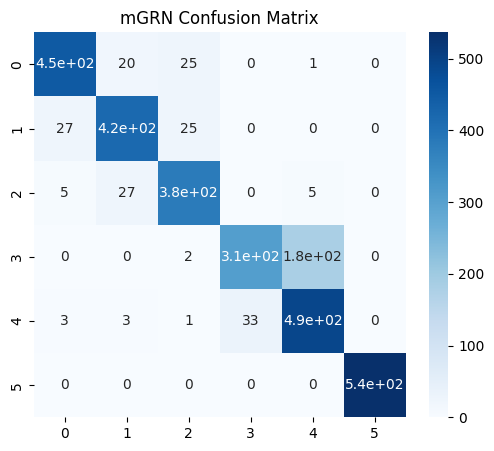


=== GRU ===
Accuracy: 0.8998982015609094
Precision: 0.8998983528827913
Recall: 0.9004616671982432
F1: 0.8995267233231887

Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       496
           1       0.92      0.96      0.94       471
           2       0.92      0.94      0.93       420
           3       0.84      0.75      0.79       491
           4       0.81      0.85      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



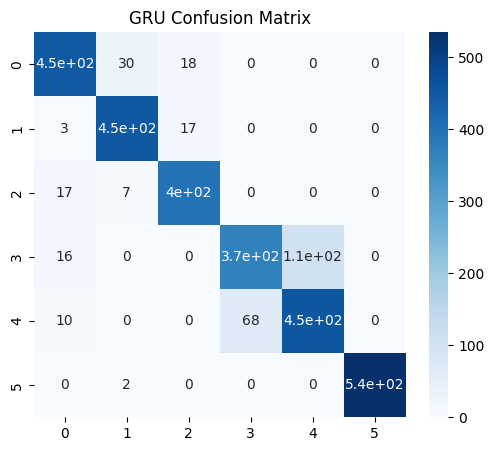


=== LSTM ===
Accuracy: 0.3963352561927384
Precision: 0.4633222430165662
Recall: 0.36819952771318815
F1: 0.2978612297264765

Report:
               precision    recall  f1-score   support

           0       0.05      0.00      0.00       496
           1       0.50      0.00      0.00       471
           2       0.00      0.00      0.00       420
           3       1.00      0.29      0.44       491
           4       0.23      1.00      0.38       532
           5       1.00      0.92      0.96       537

    accuracy                           0.40      2947
   macro avg       0.46      0.37      0.30      2947
weighted avg       0.48      0.40      0.32      2947



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

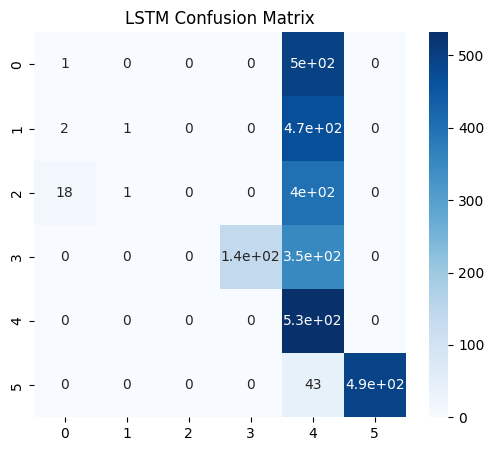

In [ ]:
def get_preds(model):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.append(out.argmax(1).cpu().numpy())
            trues.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(trues)

def evaluate(name, model):
    p, t = get_preds(model)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(t,p))
    print("Precision:", precision_score(t,p, average="macro"))
    print("Recall:", recall_score(t,p, average="macro"))
    print("F1:", f1_score(t,p, average="macro"))
    print("\nReport:\n", classification_report(t,p))

    cm = confusion_matrix(t,p)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    return accuracy_score(t,p)

acc_mgrn = evaluate("mGRN", model_mgrn)
acc_gru  = evaluate("GRU",  model_gru)
acc_lstm = evaluate("LSTM", model_lstm)


# **SECTION 9 — Final Comparison Table**

In [ ]:
df = pd.DataFrame({
    "Model": ["mGRN", "GRU", "LSTM"],
    "Accuracy": [acc_mgrn, acc_gru, acc_lstm]
})

df


,Model,Accuracy
0,mGRN,0.878181
1,GRU,0.899898
2,LSTM,0.396335


In [ ]:
# Prepare all metrics for all models
pred_mgrn, true_mgrn = get_preds(model_mgrn)
pred_gru,  true_gru  = get_preds(model_gru)
pred_lstm, true_lstm = get_preds(model_lstm)

metrics = {
    "mGRN": {
        "accuracy": accuracy_score(true_mgrn, pred_mgrn),
        "precision": precision_score(true_mgrn, pred_mgrn, average="macro"),
        "recall": recall_score(true_mgrn, pred_mgrn, average="macro"),
        "f1": f1_score(true_mgrn, pred_mgrn, average="macro")
    },
    "GRU": {
        "accuracy": accuracy_score(true_gru, pred_gru),
        "precision": precision_score(true_gru, pred_gru, average="macro"),
        "recall": recall_score(true_gru, pred_gru, average="macro"),
        "f1": f1_score(true_gru, pred_gru, average="macro")
    },
    "LSTM": {
        "accuracy": accuracy_score(true_lstm, pred_lstm),
        "precision": precision_score(true_lstm, pred_lstm, average="macro"),
        "recall": recall_score(true_lstm, pred_lstm, average="macro"),
        "f1": f1_score(true_lstm, pred_lstm, average="macro")
    }
}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **SECTION 10 - Comparing Model's Performance using Visualization**

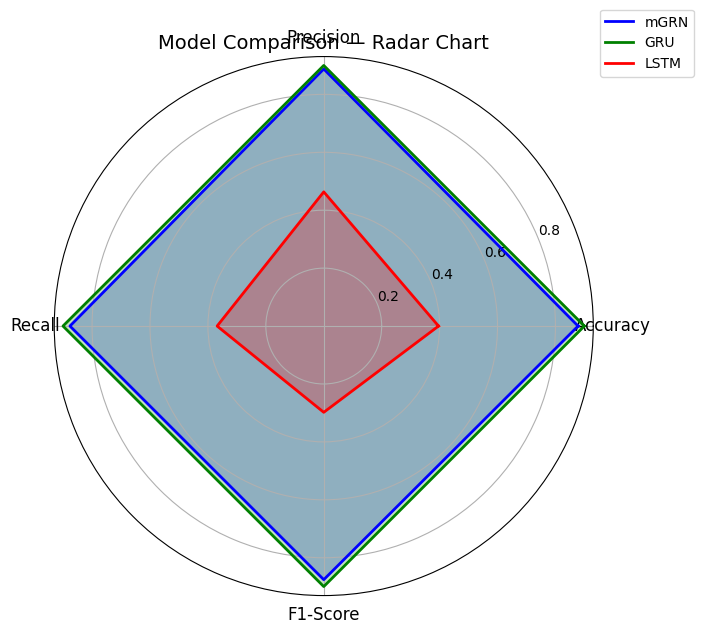

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Accuracy", "Precision", "Recall", "F1-Score"]
num_vars = len(labels)

def make_radar(values, label, color):
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    values += values[:1]     # loop back to start
    angles += angles[:1]

    ax.plot(angles, values, color=color, linewidth=2, label=label)
    ax.fill(angles, values, color=color, alpha=0.25)

# Radar chart
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Get values
mgrn_vals = list(metrics["mGRN"].values())
gru_vals  = list(metrics["GRU"].values())
lstm_vals = list(metrics["LSTM"].values())

make_radar(mgrn_vals, "mGRN", "blue")
make_radar(gru_vals, "GRU", "green")
make_radar(lstm_vals, "LSTM", "red")

ax.set_xticks(np.linspace(0, 2*np.pi, num_vars, endpoint=False))
ax.set_xticklabels(labels, fontsize=12)
ax.set_title("Model Comparison — Radar Chart", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


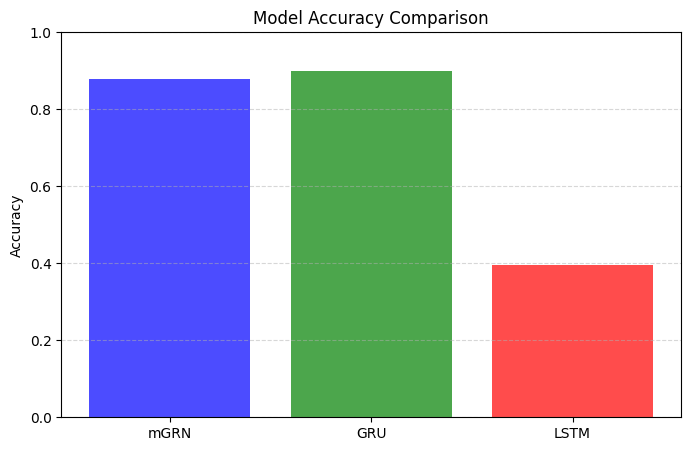

In [ ]:
plt.figure(figsize=(8,5))
models = ["mGRN", "GRU", "LSTM"]
accs = [metrics[m]["accuracy"] for m in models]

plt.bar(models, accs, color=["blue", "green", "red"], alpha=0.7)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


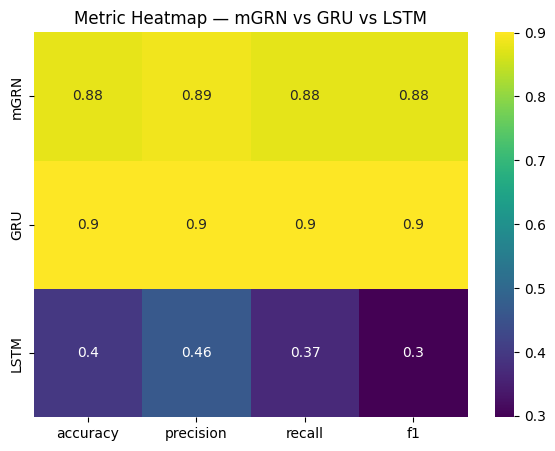

In [ ]:
metric_names = ["accuracy", "precision", "recall", "f1"]
heatmap_data = np.array([[metrics[m][k] for k in metric_names] for m in models])

plt.figure(figsize=(7,5))
sns.heatmap(heatmap_data, annot=True, cmap="viridis",
            xticklabels=metric_names, yticklabels=models)
plt.title("Metric Heatmap — mGRN vs GRU vs LSTM")
plt.show()


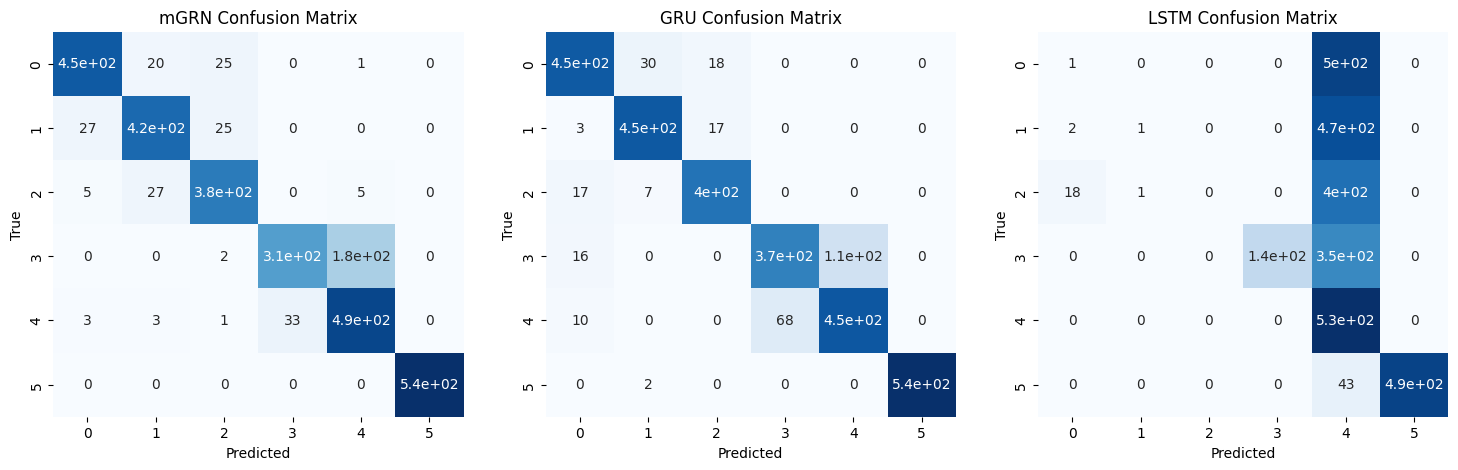

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))

for ax, (name, preds, trues) in zip(
    axs,
    [
        ("mGRN", pred_mgrn, true_mgrn),
        ("GRU", pred_gru, true_gru),
        ("LSTM", pred_lstm, true_lstm)
    ]
):
    cm = confusion_matrix(trues, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.show()
